# 1. Problem Introduction

College students and young adults often face the challenge of balancing grocery budgets with a desire to try new, interesting recipes. Many stick to buying staple items and then add ingredients only when trying a new recipe. Our project aims to solve the question: how can students and young adults maximize exposure to diverse, advanced recipes while staying within their grocery budget?

This project focuses on developing a model to optimize grocery purchases within a given budget, B, to maximize the number of meals or recipes that can be prepared.  We define an advanced recipe to be one with at least seven ingredients, and the minimum number of recipes to be made from a set of purchased ingredients to be seven. Since there may be multiple solutions to the recipe maximization model given a budget, we then minimize the money spent on ingredients. Solving these two problems provides the cheapest set of ingredients that will make the maximum possible amount of recipes given a budget.

# 2. A description of the approach used.
To approach this problem, we required data on individual recipes and their respective ingredients, including associated prices. We identified a dataset on Kaggle containing hundreds of recipes from around the world. For ingredient pricing, we used data from the U.S. Bureau of Labor Statistics for core items such as onions, apples, potatoes, and beef. However, as the Bureau does not track prices for all ingredients, we supplemented the data using Instacart for any untracked items.

For modeling in Gamspy, we defined two primary sets:
- **I**: A one-dimensional array containing the names of ingredients (e.g., onion, beef).
- **R**: A one-dimensional array containing unique recipe IDs.

Using these sets, we modeled the relationships between recipes and ingredients with the following parameters:
- **K**:  A binary indicator matrix over sets R and I, where K(r,i)=1 indicates that recipe r includes ingredient i
- **A**:  A positive matrix where A(r,i) specifies the quantity of ingredient i used in recipe r (e.g., recipe r uses 1 lb of potatoes).
- **C**:  Specifies the cost of each ingredient.
- **B**:  Upper bound on the total expenditure on ingredients.

The model also included the following variables:
- **X**: An indicator variable indexed by R, denoting whether recipe r is selected.
- **Z**: A variable indexed by I, representing the amount of ingredient i to purchase. Since only whole amounts can be purchased, Z is an integer variable >= 0
- **L**: A variable representing the leftover quantity of ingredient i, which is penalized in the objective function using the L1 norm. L >= 0
With these variables and sets, the relationships between recipes, ingredients, and costs were mathematically modeled using the following equations to optimize the selection of recipes while minimizing waste and adhering to budget constraints.


# Initial Data Reading and Cleaning

In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

df = pd.read_csv('./ingredients_refined.csv')

ingredients = np.array(df['ingredient'].str.lower().values)
price = np.array(df['price'].values)
metric = np.array(df['metric'].values)

# Initial Data Processing for Amount Matrix, the Contains Matrix, and the Cuisine Matrix

In [531]:
import json

with open('./augmented_recipes.json', 'r') as f:
    recipes = json.load(f)

matrix_recipe_ingredients = pd.DataFrame(columns=ingredients, index = [recipe['id'] for recipe in recipes])
matrix_recipe_ingredients.columns = matrix_recipe_ingredients.columns.str.strip()
matrix_recipe_contains = pd.DataFrame(columns=ingredients, index = [recipe['id'] for recipe in recipes])
matrix_recipe_contains.columns = matrix_recipe_contains.columns.str.strip()

cuisines = set()

for recipe in recipes:
    cuisines.add(recipe['cuisine'])
    for ingredient, quantity in zip(recipe["ingredients"], recipe["quantities"]):
        ingredient = ingredient.strip().lower()
        for column in matrix_recipe_ingredients.columns:
            if ingredient in column:  # Check if ingredient is a substring of the column
                matrix_recipe_ingredients.loc[recipe["id"], column] = quantity
                matrix_recipe_contains.loc[recipe["id"], column] = 1

matrix_cuisine_recipe = pd.DataFrame(columns = list(cuisines), index = [recipe['id'] for recipe in recipes])

for recipe in recipes:
    cuisine = recipe['cuisine']
    matrix_cuisine_recipe.loc[recipe["id"], cuisine] = 1


matrix_recipe_ingredients = matrix_recipe_ingredients.fillna(0)
matrix_cuisine_recipe = matrix_cuisine_recipe.fillna(0)
matrix_recipe_contains = matrix_recipe_contains.fillna(0)

/var/folders/j8/1bvzgm4101s7j3gvky9rf0mr0000gn/T/ipykernel_52570/460116402.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix_cuisine_recipe = matrix_cuisine_recipe.fillna(0)
/var/folders/j8/1bvzgm4101s7j3gvky9rf0mr0000gn/T/ipykernel_52570/460116402.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix_recipe_contains = matrix_recipe_contains.fillna(0)


# Modeling

### Set definitions

In [532]:
import gamspy as gp
import numpy as np
import gamspy.math as gpm

cont = gp.Container()
I = cont.addSet('I', records = [ingredients[idx] for idx in range(len(ingredients))], description = 'A set containing all of the valid ingredients')
R = cont.addSet('R', records = [recipe['id'] for recipe in recipes], description= 'A set containing all of the recipes that can be made')
S = cont.addSet('S', records = [1/15, 1/10, 1/5, 1/4, 1/2, 1], description="Sizes of ingredients purchasable")
Cuisines = cont.addSet('Cuisines', records = [i for i in cuisines], description = 'Different cuisines')

### Parameter Definitions

In [533]:
PPS = cont.addParameter('PPS', domain=[S], description="Price per size scalar",
                        records=np.array([[1/15], [1/10], [1/5], [1/4], [1/2], [1]]))
APS = cont.addParameter('PPS', domain=[S], description="Unit amount per size scalar",
                        records=np.array([[1/15], [1/10], [1/5], [1/4], [1/2], [1]]))

C = cont.addParameter('C', domain=[S, I], description="Cost per unit of each of the ingredients",
                      records = np.expand_dims(PPS.records['value'].to_numpy(), axis=0).T * np.tile(price, (6,1)))

A = cont.addParameter('A', domain=[R, I], description="Amount of ingredient i required in recipe r", records = np.array(matrix_recipe_ingredients))
B = cont.addParameter('B', description="Budget to purchase ingredients", records=63)

Contains = cont.addParameter('contains', domain = [R, I], description = 'Binary matrix indicating that recipe r contains ingredient i', records = np.array(matrix_recipe_contains))

### Variable Definitions

In [534]:
z = cont.addVariable('z', "integer", domain=[S, I], description="Amount of ingredient i purchased")
x = cont.addVariable('x', "binary", domain=[R], description="Indicator variable to make recipe r")
l = cont.addVariable('l', "free", domain=[I], description="Leftover ingredients after all recipes are made")
m = cont.addVariable('m', 'free', description="money spent")

### Equations

In [535]:
budget = cont.addEquation('budget', 'regular',
                        description="Constrains the total money spent on ingredients to be within the budget")
budget[:] = gp.Sum([S,I], C[S,I] * z[S,I]) <= B

ingredient_amounts = cont.addEquation('ingredient_amounts', 'regular', domain=[I],
                              description="Ensures enough ingredients are purchased to satisfy the selected recipes")
ingredient_amounts[I] = gp.Sum(R, A[R, I] * x[R]) <= gp.Sum(S, APS[S] * z[S, I])

waste = cont.addEquation('waste', 'regular', domain=[I],
                          description="Sets the leftover variable equal to the amount of unused ingredients")
waste[I] = l[I] == gp.Sum(S, APS[S] * z[S, I]) -  gp.Sum(R, A[R, I] * x[R])

tot_recipes = cont.addEquation('tot_recipes', description="Ensures enough recipes for a weeks worth of dinner can be made")
tot_recipes[:] = gp.Sum(R, x[R]) >= 7

contains_recipe = cont.addEquation('contains_recipe', description="Ensures only selecting recipes with greater than 7 ingredients", domain = [R])
contains_recipe[R] = x[R] * gp.Sum(I,Contains[R, I]) >= 7 * x[R]

money_spent = cont.addEquation('money_spent', 'regular')
money_spent[:] = m == gp.Sum([S,I], C[S,I] * z[S,I])

z.lo[S, I]= 0
l.lo[:] = 0

In [536]:
objective = gp.Sum(R, x[R]) 

recipe_optimization = cont.addModel(
    name='recipe_optimization',
    problem=gp.Problem.MIP,
    equations=cont.getEquations(),
    sense=gp.Sense.MAX,
    objective=objective
)

## Solving the Model

We first solve a single instance when the budget is $56. We are maximizing the amount of recipes that can be made with this budget.

In [537]:
B.setRecords(56)
recipe_optimization.solve(options=gp.Options(time_limit= 10))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,15,396,1092,MIP,CPLEX,0.129


Here we display the amount of ingredients purchased, how much money is spent, and the number of recipes that can be made

In [538]:
df = z.records
print(f"Amount of ingredients to purchase: {len(df[df['level'] > 0])}")
print(f"Money Spent {m.records['level'][0]}")
print(f"Recipes: {recipe_optimization.objective_value}")

Amount of ingredients to purchase: 69
Money Spent 55.978433333333335
Recipes: 15.0


Now that we have the maximum number of recipes that can be made within our budget, we enforce that thus number of recipes will be made and minimize the amount spent. To do this, we create a new modle with an additional equation that minimizes over a slightly different objective than the first.

In [539]:
max_recipe_eq = cont.addEquation('max_recipe_eq', description="The maximum number of recipes that can be made given the budget")
max_recipe_eq[:] = gp.Sum(R, x[R]) == recipe_optimization.objective_value

money_optimization = cont.addModel(
    name='money_optimization',
    problem=gp.Problem.MIP,
    equations=cont.getEquations(),
    sense=gp.Sense.MIN,
    objective=m
)
money_optimization.solve()


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,55.3173333333333,397,1092,MIP,CPLEX,0.223


Here we display how many ingredients are now purchased as well as the money spent. Again 15 recipes are made, but less money is spent on ingredients.

In [540]:
df = z.records
print(f"Amount of ingredients to purchase: {len(df[df['level'] > 0])}")
print(f"Money Spent {m.records['level'][0]}")
print(f"Recipes: {recipe_optimization.objective_value}")

Amount of ingredients to purchase: 73
Money Spent 55.31733333333332
Recipes: 15.0


Now we visualize the ingredients purchased to give us a better insight into what was bought and how much. It is important to note that the y-scale is pricing units. This means that 1 unit of salt (measured in ounces) is not the same amount as one unit of steak (measured in pounds).

In [542]:
purchased = {}
for item, scale, i in zip(z.records[z.records['level'] > 0]['level'], z.records[z.records['level'] > 0]['S'], z.records[z.records['level'] > 0]['I']):
    if i in purchased:
        purchased[i] = purchased[i] + float(item)*float(scale)
    else:
        purchased[i] = float(item)*float(scale)

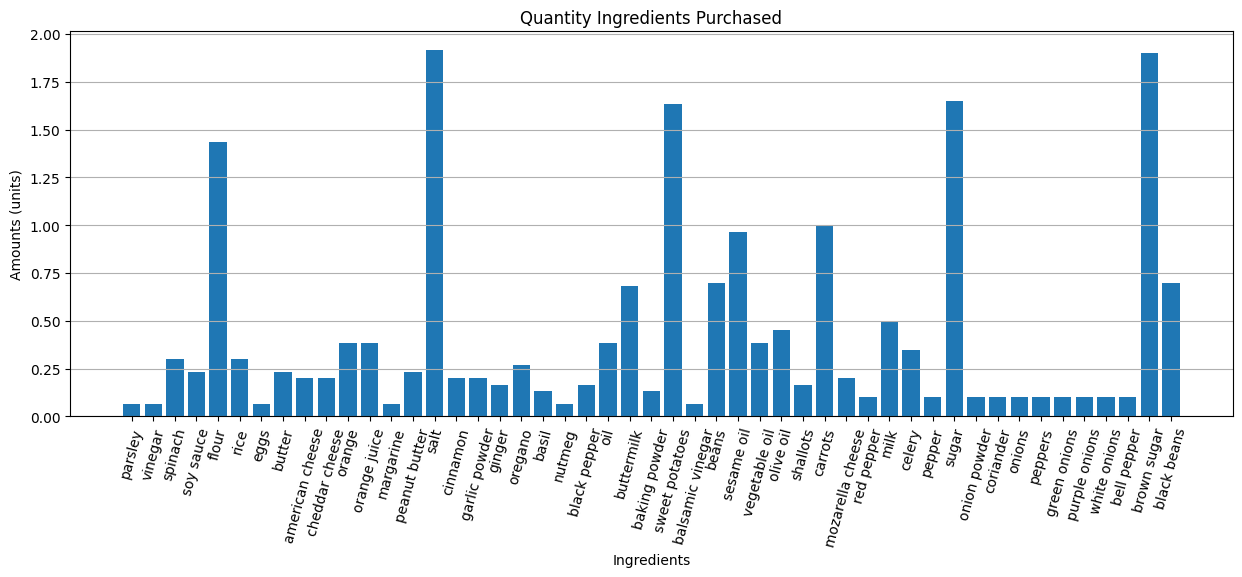

In [549]:
matplotlib.rcParams['figure.figsize'] = [15, 5]
plt.grid(which='both', axis='y')
plt.bar(purchased.keys(),purchased.values(), width=0.8)
plt.xticks(rotation=75)
plt.xlabel('Ingredients')
plt.ylabel('Amounts (units)')
plt.title('Quantity Ingredients Purchased')

plt.show()

In [552]:
print(f"Recipes to make: \n{x.records[x.records['level'] > 0]['R']}")

Recipes to make: 
13     31318
14     31027
21     18624
25      8321
26     20955
32     34367
50      1154
54     21467
68     45193
76     40064
80     45605
82     32035
93     26415
94     29801
99     37188
108    15990
Name: R, dtype: category
Categories (124, object): ['10259' < '25693' < '20130' < '6602' ... '428' < '6745' < '31009' < '20983']


Now we visualize the ingredients required for a particular recipe that was chosen by the model to be made.

Text(0.5, 1.0, 'Ingredients for Recipe 31318')

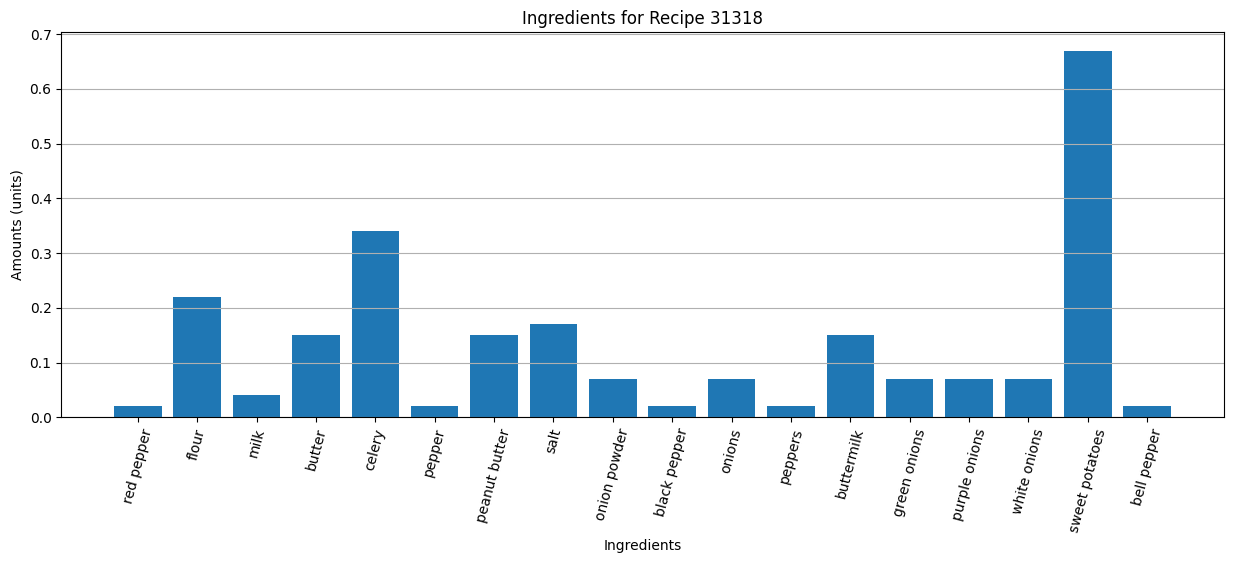

In [581]:
plt.grid(which='both', axis='y')
plt.bar(A['31318', :].records['I'].values,A['31318', :].records['value'].values, width=0.8)
plt.xticks(rotation=75)
plt.xlabel('Ingredients')
plt.ylabel('Amounts (units)')
plt.title('Ingredients for Recipe 31318')

# Sensitivity Analysis

## budget sensitivity

In [544]:
for num in range(50, 100):
    B.setRecords(num)
    recipe_optimization.solve(solver = 'cplex', options=gp.Options(time_limit=20))
    print(recipe_optimization.objective_value, num)

14.0 50
14.0 51
14.0 52
14.0 53
14.0 54
14.0 55
15.0 56
15.0 57
15.0 58
15.0 59
15.0 60
16.0 61
16.0 62
16.0 63
16.0 64
16.0 65
16.0 66


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

amount_recipes_m1 = []
amount_recipes_m2 = []
budget = []
loss = []
money_spent_m1 = []
money_spent_m2 = []


for num in range(50, 100):
    B.setRecords(num)
    recipe_optimization.solve(solver = 'cplex', options=gp.Options(time_limit=20))

    df = x.records
    money_spent_m1.append(m.records['level'])
    number_recipes = len(df[df['level'] > 0])
    amount_recipes_m1.append(number_recipes)

    # max_recipe_eq = cont.addEquation('max_recipe_eq', description="The maximum number of recipes that can be made given the budget")
    max_recipe_eq[:] = gp.Sum(R, x[R]) == recipe_optimization.objective_value
    money_optimization.solve(solver = 'cplex', options=gp.Options(time_limit=20))

    df = x.records
    number_recipes2 = len(df[df['level'] > 0])
    loss.append(l.records['level'].sum())
    budget.append(num)
    amount_recipes_m2.append(number_recipes2)
    money_spent_m2.append(money_optimization.objective_value)
    
    if num % 10 == 0:
        print(f'Budget = {num}')


14 14 50
14 14 51
14 14 52
14 14 53
14 14 54
14 14 55
15 15 56
15 15 57
15 15 58
15 15 59
15 15 60
16 16 61
16 16 62
16 16 63
16 16 64
16 16 65
16 16 66
17 17 67
17 17 68
17 17 69
17 17 70
17 17 71
17 17 72
18 18 73
18 18 74
18 18 75
18 18 76
18 18 77
18 18 78
19 19 79
19 19 80
19 19 81
19 19 82
19 19 83
19 19 84
20 20 85
20 20 86
20 20 87
20 20 88
20 20 89
20 20 90
20 20 91
21 21 92
21 21 93
21 21 94
21 21 95
21 21 96
21 21 97
22 22 98
22 22 99


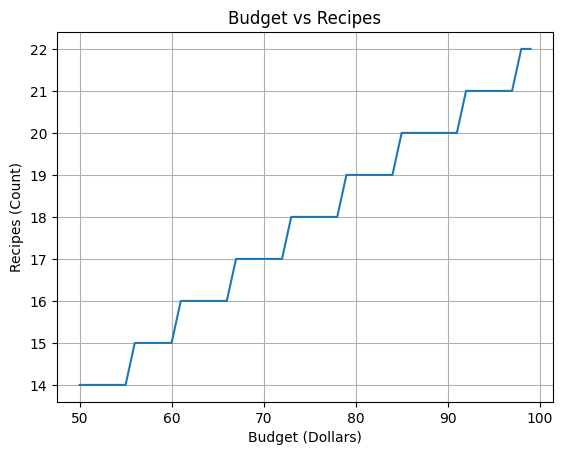

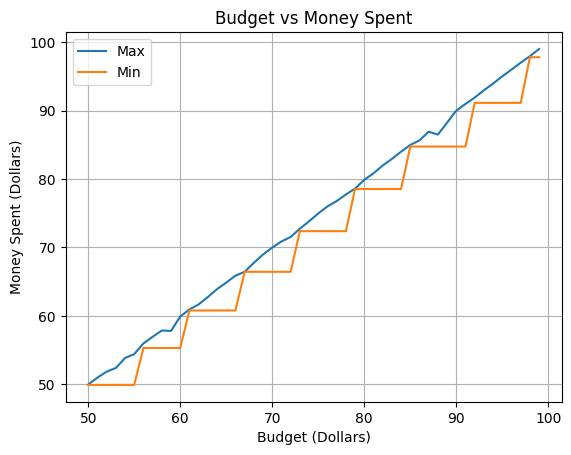

In [ ]:
import seaborn as sns

sns.lineplot(x = budget, y = amount_recipes_m1)
plt.title('Budget vs Recipes')
plt.xlabel('Budget (Dollars)')
plt.ylabel('Recipes (Count)')
plt.grid()
plt.show()

sns.lineplot(x = budget, y = [money[0] for money in money_spent_m1],legend='brief', label='Max')
sns.lineplot(x = budget, y = money_spent_m2, legend='brief', label='Min')
plt.title('Budget vs Money Spent')
plt.xlabel('Budget (Dollars)')
plt.ylabel('Money Spent (Dollars)')
plt.grid()

## Variations of Problems

Say you want to make a recipe with tomatoes
- How can this be modeled? Adding in an equation that the amount of tomatoes has to be > 0, we can add this constraint

In [ ]:
tomomatoe_equation = cont.addEquation('tomatoe_equation')
tomomatoe_equation[:] = gp.Sum(R, A[R, 'tomatoes']) >= 0


In [ ]:
tomomatoe_equation = cont.addEquation('tomatoe_equation')
tomomatoe_equation[:] = gp.Sum(R, A[R, 'tomatoes']) >= 0

B.setRecords(50)

recipe_optimization_tomatoes = cont.addModel(
    name='recipe_optimization_tomatoes',
    problem=gp.Problem.MIP,
    equations=cont.getEquations(),
    sense=gp.Sense.MAX,
    objective=objective
)
recipe_optimization_tomatoes.solve(options=gp.Options(time_limit= 10))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,IntegerInfeasible,NA,398,1093,MIP,CPLEX,0.031


In [ ]:
recipe_optimization.solve(options=gp.Options(time_limit= 10))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,14,396,1092,MIP,CPLEX,0.092
